In [1]:
from sklearn.metrics import roc_auc_score
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import datetime
parseDate = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [2]:
class EncodedDataset(Dataset):
    def __init__(self, datafile):
        super(EncodedDataset, self).__init__()
        self.data = []
        self.label = []
        self.length = []

        global input_size
        df = pd.read_csv(datafile, encoding='utf-8', sep=',', engine='python', error_bad_lines=False).drop(
            ['apdid', 'routermac'], axis=1)
        df_group = df.groupby(['target_event_id'], sort=False)
        drop_features = ['rn', 'target_event_id', 'label']
        input_size = df.shape[1] - len(drop_features)
        with tqdm(df_group, desc='loading data...') as loop:
            for target_event_id, frame in loop:
                if frame['rn'].iloc[0] != 1:
                    continue
                self.label.append(frame['label'].iloc[0])
                frame.sort_values(['rn'], inplace=True, ascending=False)
                x = frame.drop(drop_features, axis=1).to_numpy()
                self.data.append(x)
                self.length.append(len(x))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):
        return self.data[item], self.label[item], self.length[item]


def collate_fn(batch):
    inputs, labels, lengths = zip(*batch)
    inputs_pad = pad_sequence([torch.from_numpy(x) for x in inputs], padding_value=0)
    return inputs_pad.float().to(device), torch.LongTensor(labels).to(device), torch.LongTensor(lengths).to(device)


# HK

In [6]:
with open("HK_time.pkl","rb") as fp:
    timeMap = pickle.load(fp)

In [2]:
datafile = "E:\\数据集\\蚂蚁数据\\data\\split_data\\antfin\\HK_sample\\HK_sample\\csv\\train_2020-01.csv"

In [8]:
# laoding month
df = pd.read_csv(datafile, encoding='utf-8', sep=',', engine='python', error_bad_lines=False).drop(['apdid', 'routermac'], axis=1)
#target_event_id_list = []
time_list = []
df_group = df.groupby(['target_event_id'], sort=False)
drop_features = ['rn', 'target_event_id', 'label']
input_size = df.shape[1] - len(drop_features)
with tqdm(df_group, desc='loading data...') as loop:
    for target_event_id, frame in loop:
        if frame['rn'].iloc[0] != 1:
            continue
        #target_event_id_list.append(frame['target_event_id'].iloc[0])
        time_list.append(timeMap[target_event_id])
        

loading data...: 100%|███████████████████████████████████████████████████████████| 8544/8544 [00:01<00:00, 6903.18it/s]


In [7]:
# loading amount
amount_list = []
df = pd.read_csv(datafile, encoding='utf-8', sep=',', engine='python', error_bad_lines=False).drop(['apdid', 'routermac'], axis=1)
#target_event_id_list = []
df_group = df.groupby(['target_event_id'], sort=False)
drop_features = ['rn', 'target_event_id', 'label']
input_size = df.shape[1] - len(drop_features)
with tqdm(df_group, desc='loading data...') as loop:
    for target_event_id, frame in loop:
        if frame['rn'].iloc[0] != 1:
            continue
        #target_event_id_list.append(frame['target_event_id'].iloc[0])
        amount_list.append(frame['event_amount'].iloc[0])
amount_list = np.array(amount_list)

loading data...: 100%|███████████████████████████████████████████████████████████| 8544/8544 [00:01<00:00, 4829.85it/s]


In [16]:
with open("HK_2020-01_amount.pkl","wb") as fp:
    pickle.dump(amount_list,fp)

In [2]:
with open("HK_2020-01_amount.pkl","rb") as fp:
    amount_list = pickle.load(fp)

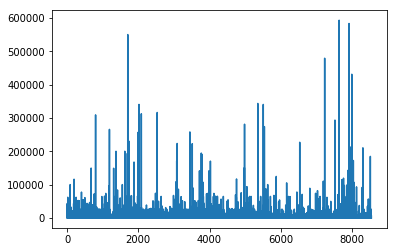

In [3]:
plt.plot(amount_list)

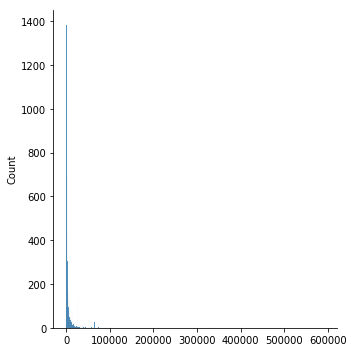

In [4]:
sns.displot(amount_list)

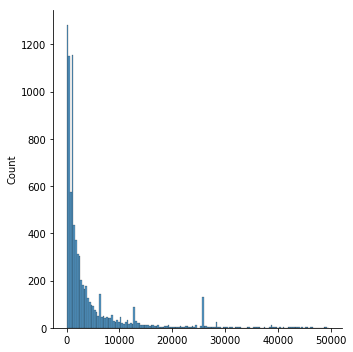

In [4]:
sns.displot(amount_list[amount_list<50000])

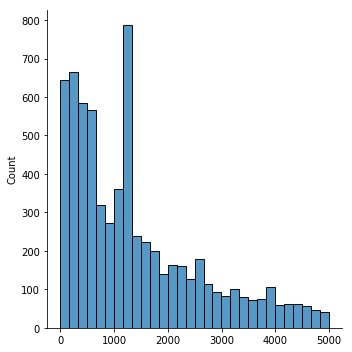

In [5]:
sns.displot(amount_list[amount_list<5000])

In [8]:
len(np.where(amount_list<500)[0])/len(amount_list)

0.22167602996254682

In [9]:
len(np.where(amount_list<100)[0])/len(amount_list)

0.032186329588014984

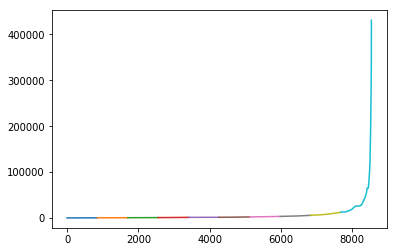

In [38]:
sorted_index = np.argsort(amount_list)
num_records = len(sorted_index)
amount_indices_list = []
amount_split_bins = 10 # 
num_bin = num_records//amount_split_bins
for i in range(amount_split_bins):
    amount_indices_list.append(sorted_index[i*num_bin:(i+1)*num_bin])
for i in range(amount_split_bins):
    plt.plot(np.arange(i*num_bin,(i+1)*num_bin),amount_list[amount_indices_list[i]])

In [17]:
'''
with open("HK_time_list.pkl","wb") as fp:
    pickle.dump(time_list,fp)
with open("HK_time_list.pkl","rb") as fp:
    time_list = pickle.load(fp)

'''

'\nwith open("HK_time_list.pkl","wb") as fp:\n    pickle.dump(time_list,fp)\nwith open("HK_time_list.pkl","rb") as fp:\n    time_list = pickle.load(fp)\n\n'

In [30]:
time_list[-1]

'2020-06-30 23:51:05'

In [6]:
rep_file = "E:\\GitHub\\Fraud_Detection\\Transfer\\HK_2020-01_lstm_rep.pkl"
with open(rep_file,"rb") as fp:
    rep_data = pickle.load(fp)

In [7]:
rep_data["rep"].shape

(8544, 300)

In [16]:
tsne = TSNE(n_components=2)
trans_data = tsne.fit_transform(rep_data["rep"]) 

In [26]:
time_list[ind].day

2

In [31]:
time_list = [parseDate(x) for x in time_list]
month_list = [x.month for x in time_list]
day_list = [x.day for x in time_list]
month_list = np.array(month_list)
day_list = np.array(day_list)

In [11]:
with open("HK_2020-01_month.pkl","wb") as fp:
    pickle.dump(month_list,fp)

In [32]:
with open("HK_2020-01_day.pkl","wb") as fp:
    pickle.dump(day_list,fp)

In [ ]:
# if exists, loading

In [51]:
with open("HK_2020-01_month.pkl","rb") as fp:
    month_list = pickle.load(fp)

In [52]:
with open("HK_2020-01_day.pkl","rb") as fp:
    day_list = pickle.load(fp)

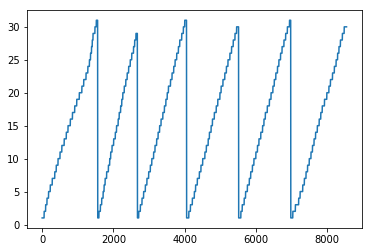

In [53]:
plt.plot(day_list)

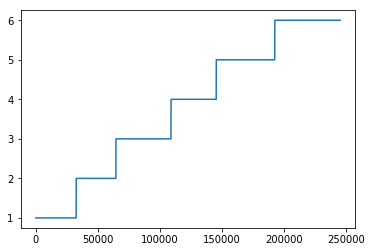

In [54]:
plt.plot(month_indicator)

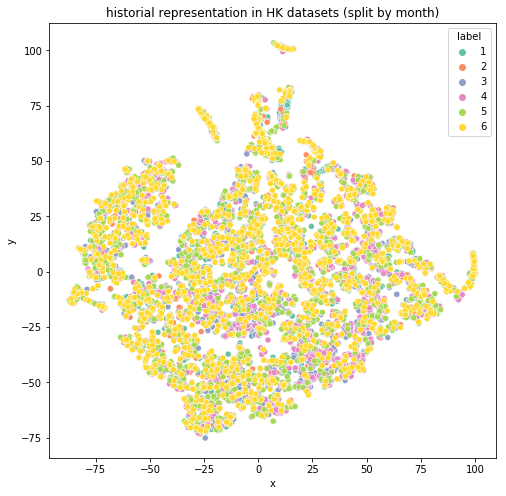

In [14]:
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":month_list})
plt.figure(figsize=(8,8))
plt.title("historial representation in HK datasets (split by month)")
sns.scatterplot(x="x",y="y",data=vis_df,hue="label",palette="Set2")

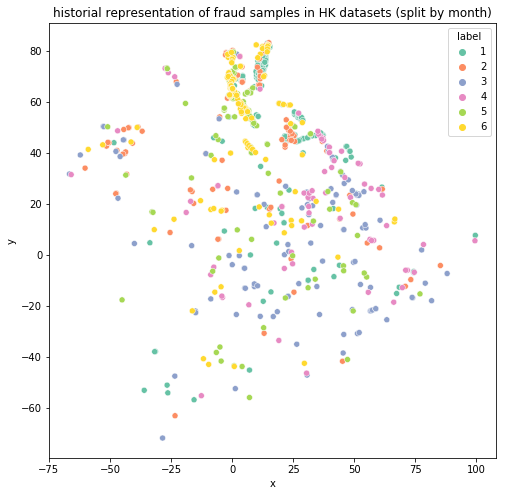

In [15]:
indices_1 = np.where(np.array(rep_data["label"]) ==1)[0]
vis_df = pd.DataFrame({"x":trans_data[indices_1,0],"y":trans_data[indices_1,1],"label":month_list[indices_1]})
plt.figure(figsize=(8,8))
plt.title("historial representation of fraud samples in HK datasets (split by month)")
sns.scatterplot(x="x",y="y",data=vis_df,hue="label",palette="Set2")

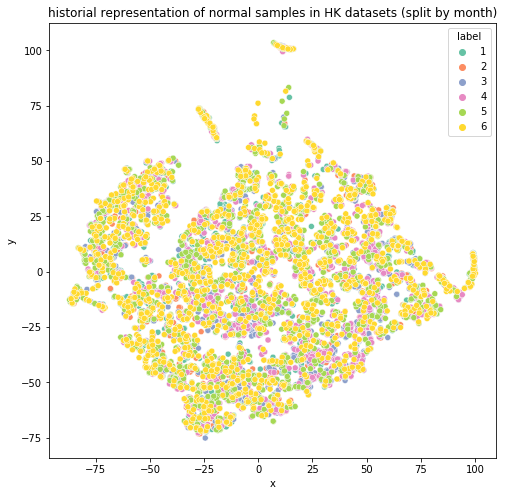

In [16]:
indices_0 = np.where(np.array(rep_data["label"]) ==0)[0]
vis_df = pd.DataFrame({"x":trans_data[indices_0,0],"y":trans_data[indices_0,1],"label":month_list[indices_0]})
plt.figure(figsize=(8,8))
plt.title("historial representation of normal samples in HK datasets (split by month)")
sns.scatterplot(x="x",y="y",data=vis_df,hue="label",palette="Set2")

Text(0.5, 1.0, 'historial representation of fraud samples in HK datasets (split by month)')

<Figure size 576x576 with 0 Axes>

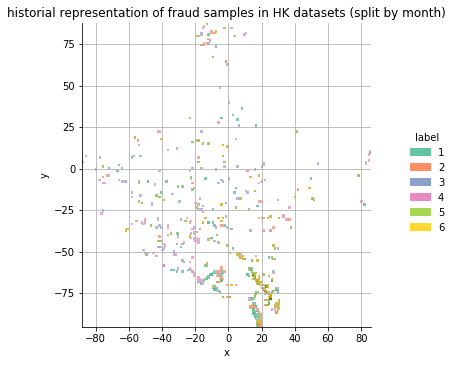

In [17]:
plt.figure(figsize=(8,8))
indices_1 = np.where(np.array(rep_data["label"]) ==1)[0]
vis_df = pd.DataFrame({"x":trans_data[indices_1,0],"y":trans_data[indices_1,1],"label":month_list[indices_1]})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("historial representation of fraud samples in HK datasets (split by month)")

Text(0.5, 1.0, 'historial representation of normal samples in HK datasets (split by month)')

<Figure size 576x576 with 0 Axes>

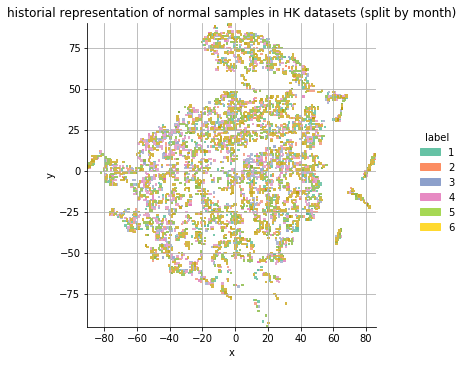

In [18]:
plt.figure(figsize=(8,8))
indices_0 = np.where(np.array(rep_data["label"]) == 0)[0]
vis_df = pd.DataFrame({"x":trans_data[indices_0,0],"y":trans_data[indices_0,1],"label":month_list[indices_0]})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("historial representation of normal samples in HK datasets (split by month)")

In [19]:
month_indicator = np.unique(month_list)
month_centroid_list = []
for mon in month_indicator:
    indices = np.where(month_list==mon)[0]
    month_centroid_list.append(trans_data[indices].mean(axis=0))      
month_centroid = np.stack(month_centroid_list,axis=0)

<Figure size 576x576 with 0 Axes>

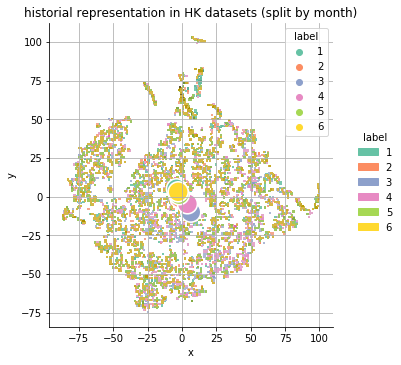

In [20]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":month_list})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("historial representation in HK datasets (split by month)")
vis_df_1 = pd.DataFrame({"x":month_centroid[:,0],"y":month_centroid[:,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_1,hue="label",palette="Set2",s=400)

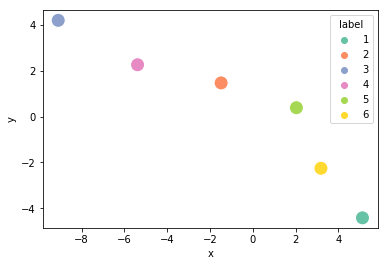

In [48]:
vis_df_1 = pd.DataFrame({"x":month_centroid[:,0],"y":month_centroid[:,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_1,hue="label",palette="Set2",s=200)

In [11]:
# split by month and data
label_list = np.array(rep_data["label"]).squeeze()
label_0_bool = label_list == 0
label_1_bool = label_list == 1

month_indicator = np.unique(month_list)
month_centroid_list = []
for mon in month_indicator:
    month_indices_0 = np.where((month_list==mon)& label_0_bool)[0]
    month_indices_1 = np.where((month_list==mon)& label_1_bool)[0]
    month_centroid_list.append([trans_data[month_indices_0].mean(axis=0),trans_data[month_indices_1].mean(axis=0)])
month_centroid = np.array(month_centroid_list) # num_centroid, label_dimension, coordinate

In [12]:
month_centroid

array([[[ -4.0030813,  -5.525562 ],
        [-25.799885 ,  50.84558  ]],

       [[  2.077491 ,  -4.3008976],
        [-29.833954 ,  36.855698 ]],

       [[ 11.27856  ,  -3.8324726],
        [ 12.496884 ,  25.060947 ]],

       [[  5.5648046,  -1.9325784],
        [  6.6074486,  35.31713  ]],

       [[ -0.9755229,  -3.9642289],
        [-22.180943 ,  36.529377 ]],

       [[ -1.0967678,  -3.492916 ],
        [-33.377125 ,  42.662632 ]]], dtype=float32)

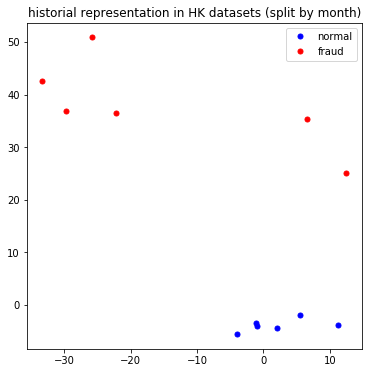

In [44]:
plt.figure(figsize=(6,6))
plt.title("historial representation in HK datasets (split by month)")
#vis_df_1 = pd.DataFrame({"x":month_centroid[:,0,0],"y":month_centroid[:,0,1],"label":month_indicator})
plt.plot(month_centroid[:,0,0],month_centroid[:,0,1],'b.',ms=10,label="normal")
plt.plot(month_centroid[:,1,0],month_centroid[:,1,1],'r.',ms=10,label="fraud")
plt.legend()

<Figure size 576x576 with 0 Axes>

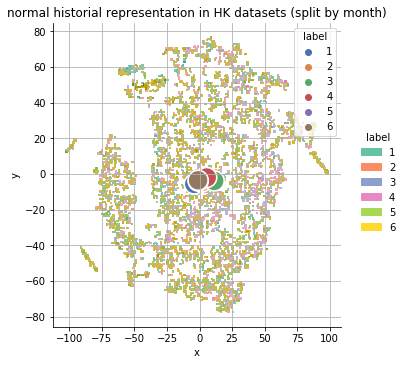

In [14]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":month_list})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("normal historial representation in HK datasets (split by month)")

vis_df_1 = pd.DataFrame({"x":month_centroid[:,0,0],"y":month_centroid[:,0,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_1,hue="label",palette ="deep",s=400)


<Figure size 576x576 with 0 Axes>

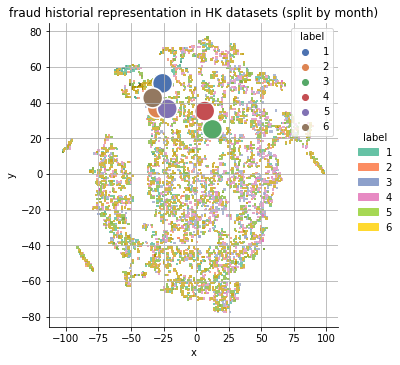

In [16]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":month_list})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("fraud historial representation in HK datasets (split by month)")


vis_df_2 = pd.DataFrame({"x":month_centroid[:,1,0],"y":month_centroid[:,1,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_2,hue="label",palette ="deep",s=400)

<Figure size 576x576 with 0 Axes>

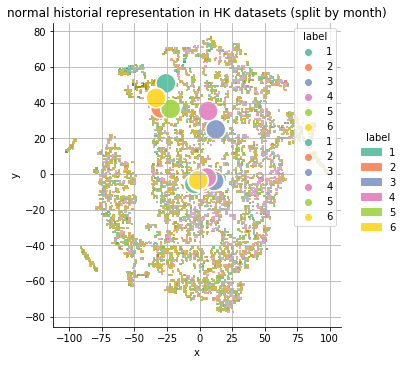

In [29]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":month_list})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("historial representation in HK datasets (split by month)")

vis_df_1 = pd.DataFrame({"x":month_centroid[:,0,0],"y":month_centroid[:,0,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_1,hue="label",palette ="Set2",s=400)

vis_df_2 = pd.DataFrame({"x":month_centroid[:,1,0],"y":month_centroid[:,1,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_2,hue="label",palette ="Set2",s=400)

# kmeans cluster

In [6]:
# split by label & month
num_clusters = 5

In [7]:
rep_file = "E:\\GitHub\\Fraud_Detection\\Transfer\\HK_2020-01_lstm_rep.pkl"
with open(rep_file,"rb") as fp:
    rep_data = pickle.load(fp)
labels = np.array(rep_data["label"])

indices_0 = np.where(labels==0)[0]
indices_1 = np.where(labels==1)[0]

model_0 = KMeans(n_clusters=num_clusters, random_state=0).fit(rep_data["rep"][indices_0])
model_1 = KMeans(n_clusters=num_clusters, random_state=0).fit(rep_data["rep"][indices_1])
model_1.labels_  = model_1.labels_ + num_clusters

cluster_indicator = np.zeros_like(labels)
cluster_indicator[indices_0] = model_0.labels_.reshape([-1,1])
cluster_indicator[indices_1] = model_1.labels_.reshape([-1,1])
cluster_indicator = np.squeeze(cluster_indicator)

In [69]:
np.unique(cluster_indicator)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [67]:
with open("HK_2020-01_month_cluster.pkl","wb") as fp:
    pickle.dump(cluster_indicator,fp)

In [68]:
with open("HK_2020-01_month_cluster.pkl","rb") as fp:
    cluster_indicator = pickle.load(fp)

Text(0.5, 1.0, 'historial representation in HK datasets (split by month)')

<Figure size 576x576 with 0 Axes>

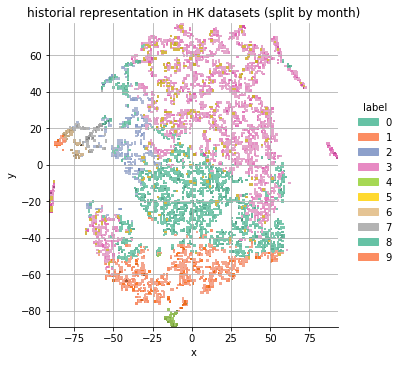

In [53]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":cluster_indicator.squeeze()})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("historial representation in HK datasets (split by month)")


Text(0.5, 1.0, 'normal historial representation in HK datasets (split by month)')

<Figure size 576x576 with 0 Axes>

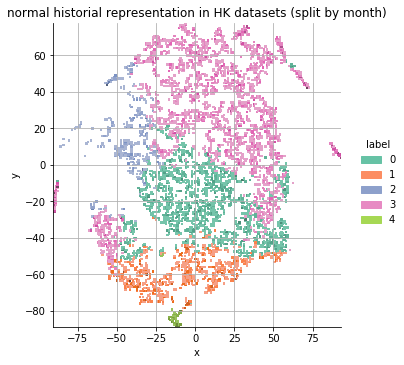

In [54]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[indices_0,0],"y":trans_data[indices_0,1],"label":model_0.labels_})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("normal historial representation in HK datasets (split by month)")


Text(0.5, 1.0, 'fraud historial representation in HK datasets (split by month)')

<Figure size 576x576 with 0 Axes>

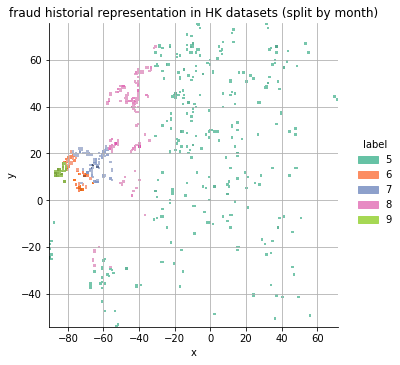

In [55]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[indices_1,0],"y":trans_data[indices_1,1],"label":model_1.labels_})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("fraud historial representation in HK datasets (split by month)")


In [8]:
# LZD datasets
rep_file = "E:\\GitHub\\Fraud_Detection\\Transfer\\LZD_2020-01_lstm_rep.pkl"
with open(rep_file,"rb") as fp:
    rep_data = pickle.load(fp)
labels = np.array(rep_data["label"])

indices_0 = np.where(labels==0)[0]
indices_1 = np.where(labels==1)[0]

model_0 = KMeans(n_clusters=num_clusters, random_state=0).fit(rep_data["rep"][indices_0])
model_1 = KMeans(n_clusters=num_clusters, random_state=0).fit(rep_data["rep"][indices_1])
model_1.labels_  = model_1.labels_ + num_clusters

cluster_indicator = np.zeros_like(labels)
cluster_indicator[indices_0] = model_0.labels_.reshape([-1,1])
cluster_indicator[indices_1] = model_1.labels_.reshape([-1,1])
cluster_indicator = np.squeeze(cluster_indicator)

In [74]:
np.unique(cluster_indicator)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [72]:
with open("LZD_2020-01_month_cluster.pkl","wb") as fp:
    pickle.dump(cluster_indicator,fp)

In [9]:
with open("LZD_2020-01_month_cluster.pkl","rb") as fp:
    cluster_indicator = pickle.load(fp)

In [10]:
cluster_indicator.shape

(245045,)

Text(0.5, 1.0, 'historial representation in LZD datasets (split by month)')

<Figure size 576x576 with 0 Axes>

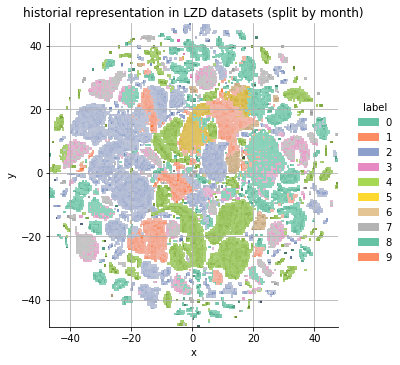

In [12]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":cluster_indicator.squeeze()})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("historial representation in LZD datasets (split by month)")


Text(0.5, 1.0, 'normal historial representation in LZD datasets (split by month)')

<Figure size 576x576 with 0 Axes>

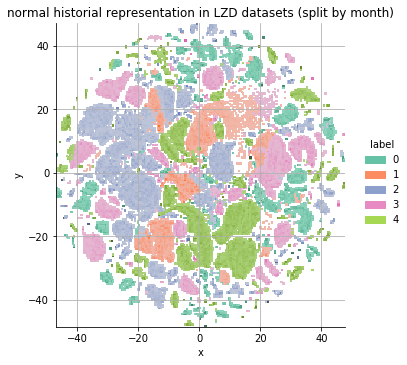

In [13]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[indices_0,0],"y":trans_data[indices_0,1],"label":model_0.labels_})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("normal historial representation in LZD datasets (split by month)")


Text(0.5, 1.0, 'fraud historial representation in LZD datasets (split by month)')

<Figure size 576x576 with 0 Axes>

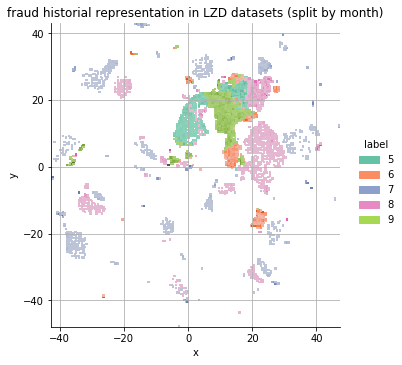

In [14]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[indices_1,0],"y":trans_data[indices_1,1],"label":model_1.labels_})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("fraud historial representation in LZD datasets (split by month)")


# LZD

In [45]:
with open("LZD_time.pkl","rb") as fp:
    timeMap = pickle.load(fp)

In [45]:
datafile = "E:\\数据集\\蚂蚁数据\\data\\split_data\\antfin\\LZD\\csv\\train_2020-01.csv"

In [5]:
#if os.exist()"LZD_time_list.pkl"

df = pd.read_csv(datafile, encoding='utf-8', sep=',', engine='python', error_bad_lines=False).drop(['apdid', 'routermac'], axis=1)
#target_event_id_list = []
time_list = []
df_group = df.groupby(['target_event_id'], sort=False)
drop_features = ['rn', 'target_event_id', 'label']
input_size = df.shape[1] - len(drop_features)
with tqdm(df_group, desc='loading data...') as loop:
    for target_event_id, frame in loop:
        if frame['rn'].iloc[0] != 1:
            continue
        #target_event_id_list.append(frame['target_event_id'].iloc[0])
        time_list.append(timeMap[target_event_id])
        

loading data...: 100%|███████████████████████████████████████████████████████| 245156/245156 [00:29<00:00, 8238.69it/s]


In [6]:
with open("LZD_time_list.pkl","wb") as fp:
    pickle.dump(time_list,fp)

In [39]:
with open("LZD_time_list.pkl","rb") as fp:
    time_list = pickle.load(fp)

In [46]:
# loading amount
amount_list = []
df = pd.read_csv(datafile, encoding='utf-8', sep=',', engine='python', error_bad_lines=False).drop(['apdid', 'routermac'], axis=1)
#target_event_id_list = []
df_group = df.groupby(['target_event_id'], sort=False)
drop_features = ['rn', 'target_event_id', 'label']
input_size = df.shape[1] - len(drop_features)
with tqdm(df_group, desc='loading data...') as loop:
    for target_event_id, frame in loop:
        if frame['rn'].iloc[0] != 1:
            continue
        #target_event_id_list.append(frame['target_event_id'].iloc[0])
        amount_list.append(frame['event_amount'].iloc[0])
amount_list = np.array(amount_list)

loading data...: 100%|███████████████████████████████████████████████████████| 245156/245156 [00:48<00:00, 5078.81it/s]


In [47]:
with open("LZD_2020-01_amount.pkl","wb") as fp:
    pickle.dump(amount_list,fp)

In [5]:
with open("LZD_2020-01_amount.pkl","rb") as fp:
    amount_list = pickle.load(fp)

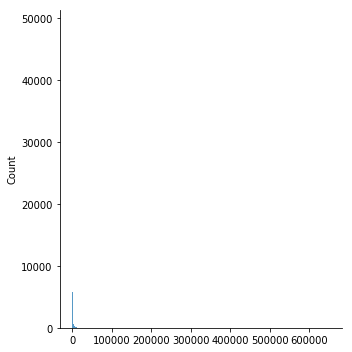

In [6]:
sns.displot(amount_list)

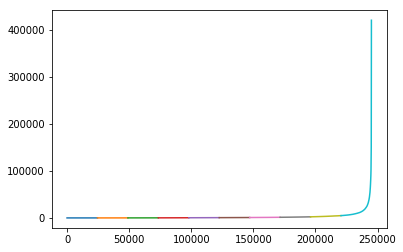

In [50]:
sorted_index = np.argsort(amount_list)
num_records = len(sorted_index)
amount_indices_list = []
amount_split_bins = 10 # 
num_bin = num_records//amount_split_bins
for i in range(amount_split_bins):
    amount_indices_list.append(sorted_index[i*num_bin:(i+1)*num_bin])
for i in range(amount_split_bins):
    plt.plot(np.arange(i*num_bin,(i+1)*num_bin),amount_list[amount_indices_list[i]])

In [40]:
time_list[-1]

'2020-06-30 23:59:48'

In [11]:
rep_file = "E:\\GitHub\\Fraud_Detection\\Transfer\\LZD_2020-01_lstm_rep.pkl"
with open(rep_file,"rb") as fp:
    rep_data = pickle.load(fp)

In [76]:
tsne = TSNE(n_components=2)
trans_data = tsne.fit_transform(rep_data["rep"]) 

In [77]:
with open("LZD_2020-01_trans_data.pkl","wb") as fp:
    pickle.dump(trans_data,fp)

In [2]:
with open("LZD_2020-01_trans_data.pkl","rb") as fp:
    trans_data = pickle.load(fp)

In [41]:
time_list = [parseDate(x) for x in time_list]
month_list = [x.month for x in time_list]
day_list = [x.day for x in time_list]
month_indicator = np.array(month_list)
day_indicator = np.array(day_list)

In [25]:
with open("LZD_2020-01_month.pkl","wb") as fp:
    pickle.dump(month_indicator,fp)

In [42]:
with open("LZD_2020-01_day.pkl","wb") as fp:
    pickle.dump(day_indicator,fp)

In [ ]:
# loading

In [2]:
with open("LZD_2020-01_month.pkl","rb") as fp:
    month_indicator = pickle.load(fp)

In [3]:
with open("LZD_2020-01_day.pkl","rb") as fp:
    day_indicator = pickle.load(fp)

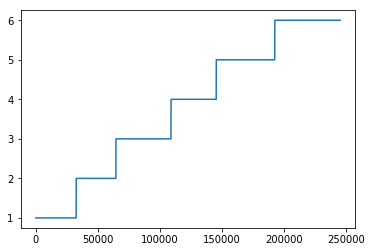

In [58]:
plt.plot(month_indicator)

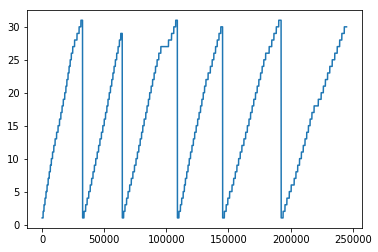

In [8]:
plt.plot(day_indicator)

In [5]:
def calcu_day_15_indices(day_indicator):
    middle_indices = np.where(day_indicator==15)[0]
    max_item_indices = []
    for i in range(len(middle_indices)-1):
        if middle_indices[i] == (middle_indices[i+1] - 1):
            continue
        else:
            max_item_indices.append(middle_indices[i])
    max_item_indices.append(middle_indices[-1])
    return max_item_indices

In [9]:
day_15_indices = calcu_day_15_indices(day_indicator)

In [18]:
ind = 0
rep_data["rep"][day_15_indices[ind]:day_15_indices[ind+1]].shape

(36002, 300)

In [10]:
day_15_indices

[13922, 49924, 82061, 125135, 166462, 215666]

In [ ]:
indices_1 = np.where(np.array(rep_data["label"]) ==1)[0]
vis_df = pd.DataFrame({"x":trans_data[indices_1,0],"y":trans_data[indices_1,1],"label":month_list[indices_1]})

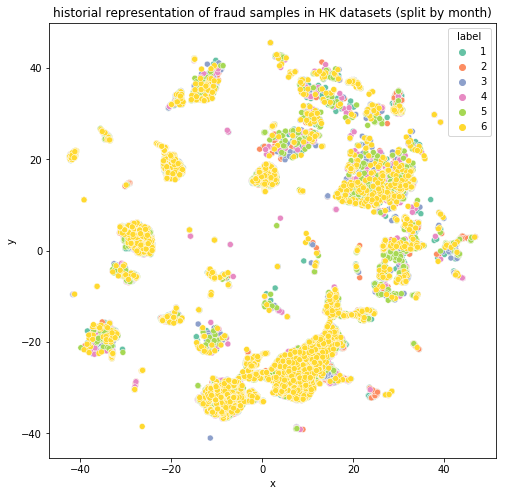

In [75]:
plt.figure(figsize=(8,8))
plt.title("historial representation of fraud samples in HK datasets (split by month)")
sns.scatterplot(x="x",y="y",data=vis_df,hue="label",palette="Set2")

Text(0.5, 1.0, 'historial representation of fraud samples in HK datasets (split by month)')

<Figure size 576x576 with 0 Axes>

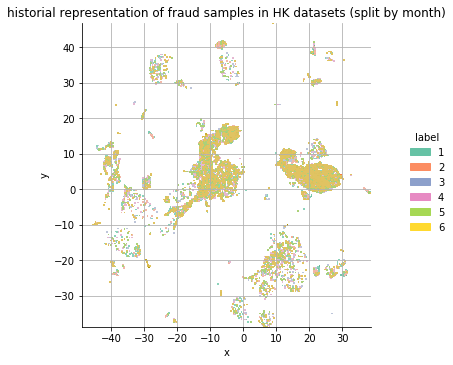

In [40]:
plt.figure(figsize=(8,8))
indices_1 = np.where(np.array(rep_data["label"]) ==1)[0]
vis_df = pd.DataFrame({"x":trans_data[indices_1,0],"y":trans_data[indices_1,1],"label":month_list[indices_1]})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=400)
plt.title("historial representation of fraud samples in HK datasets (split by month)")

In [11]:
indices_0 = np.where(np.array(rep_data["label"]) ==0)[0]
vis_df = pd.DataFrame({"x":trans_data[indices_0,0],"y":trans_data[indices_0,1],"label":month_list[indices_0]})

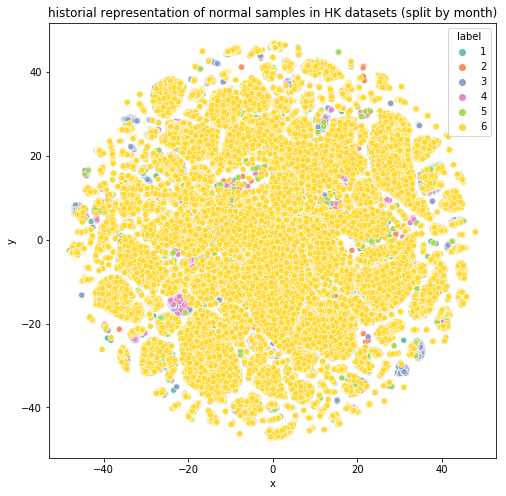

In [12]:
plt.figure(figsize=(8,8))
plt.title("historial representation of normal samples in HK datasets (split by month)")
sns.scatterplot(x="x",y="y",data=vis_df,hue="label",palette="Set2")

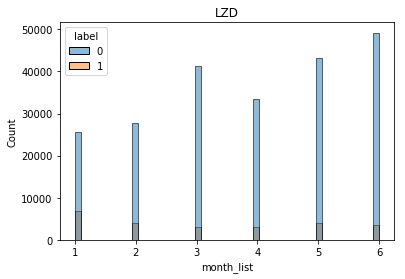

In [41]:
plt.title("LZD")
vis_df = pd.DataFrame({"month_list":month_list,"label":np.array(rep_data["label"]).squeeze()})
sns.histplot(x="month_list",data=vis_df,hue="label")

In [55]:
month_indicator = np.unique(month_list)
month_centroid_list = []
for mon in month_indicator:
    indices = np.where(month_list==mon)[0]
    month_centroid_list.append(trans_data[indices].mean(axis=0))      
month_centroid = np.stack(month_centroid_list,axis=0)

<Figure size 576x576 with 0 Axes>

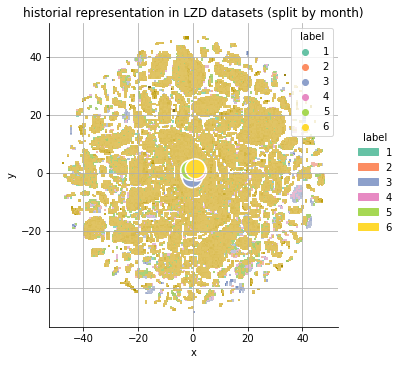

In [80]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":month_list})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("historial representation in LZD datasets (split by month)")
vis_df_1 = pd.DataFrame({"x":month_centroid[:,0],"y":month_centroid[:,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_1,hue="label",palette="Set2",s=400)

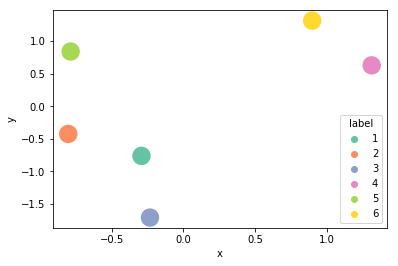

In [83]:
#plt.figure(figsize=(8,8))
vis_df_1 = pd.DataFrame({"x":month_centroid[:,0],"y":month_centroid[:,1],"label":month_indicator})
#plt.title("centroid historial representations in LZD datasets (split by month)")
sns.scatterplot(x="x",y="y",data=vis_df_1,hue="label",palette="Set2",s=400)

In [56]:
# split by month and label
label_list = np.array(rep_data["label"]).squeeze()
label_0_bool = label_list == 0
label_1_bool = label_list == 1

month_indicator = np.unique(month_list)
month_centroid_list = []
for mon in month_indicator:
    month_indices_0 = np.where((month_list==mon)& label_0_bool)[0]
    month_indices_1 = np.where((month_list==mon)& label_1_bool)[0]
    month_centroid_list.append([trans_data[month_indices_0].mean(axis=0),trans_data[month_indices_1].mean(axis=0)])
month_centroid = np.array(month_centroid_list) # num_centroid, label_dimension, coordinate

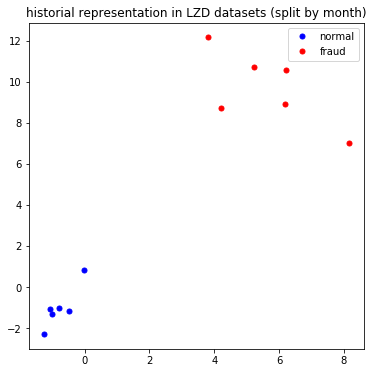

In [57]:
plt.figure(figsize=(6,6))
plt.title("historial representation in LZD datasets (split by month)")
#vis_df_1 = pd.DataFrame({"x":month_centroid[:,0,0],"y":month_centroid[:,0,1],"label":month_indicator})
plt.plot(month_centroid[:,0,0],month_centroid[:,0,1],'b.',ms=10,label="normal")
plt.plot(month_centroid[:,1,0],month_centroid[:,1,1],'r.',ms=10,label="fraud")
plt.legend()

<Figure size 576x576 with 0 Axes>

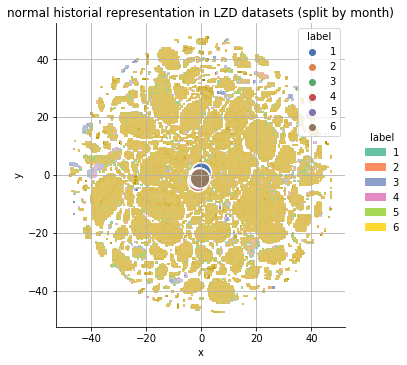

In [61]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":month_list})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("normal historial representation in LZD datasets (split by month)")

vis_df_2 = pd.DataFrame({"x":month_centroid[:,0,0],"y":month_centroid[:,0,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_2,hue="label",palette ="deep",s=400)


<Figure size 576x576 with 0 Axes>

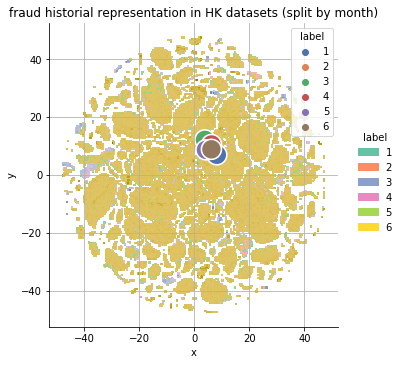

In [60]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":month_list})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("fraud historial representation in HK datasets (split by month)")


vis_df_2 = pd.DataFrame({"x":month_centroid[:,1,0],"y":month_centroid[:,1,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_2,hue="label",palette ="deep",s=400)

<Figure size 576x576 with 0 Axes>

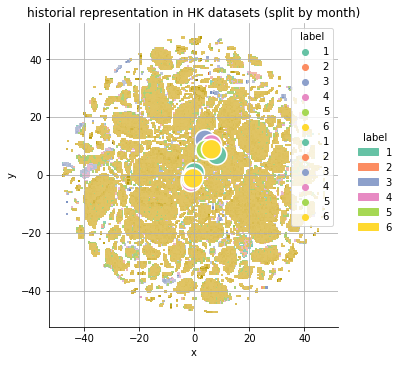

In [62]:
plt.figure(figsize=(8,8))
vis_df = pd.DataFrame({"x":trans_data[:,0],"y":trans_data[:,1],"label":month_list})
sns.displot(x="x",y="y",data=vis_df,hue="label",palette="Set2",bins=200)
plt.title("historial representation in HK datasets (split by month)")

vis_df_1 = pd.DataFrame({"x":month_centroid[:,0,0],"y":month_centroid[:,0,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_1,hue="label",palette ="Set2",s=400)

vis_df_2 = pd.DataFrame({"x":month_centroid[:,1,0],"y":month_centroid[:,1,1],"label":month_indicator})
sns.scatterplot(x="x",y="y",data=vis_df_2,hue="label",palette ="Set2",s=400)

# generate month list (split by month and label)

In [37]:
with open("HK_time_list.pkl","rb") as fp:
    time_list = pickle.load(fp)

In [38]:
time_list = [parseDate(x) for x in time_list]
month_list = [x.month for x in time_list]

In [25]:
rep_file = "E:\\GitHub\\Fraud_Detection\\Transfer\\HK_2020-01_lstm_rep.pkl"
with open(rep_file,"rb") as fp:
    rep_data = pickle.load(fp)

In [26]:
time_list[-1]

datetime.datetime(2020, 6, 30, 23, 51, 5)

In [40]:
label_HK = np.array(rep_data["label"])
for i in range(len(label_HK)):
    if label_HK[i] == 1:
        month_list[i] = month_list[i] + 6
month_list = np.array(month_list)

In [48]:
with open("HK_2020-01_month_label.pkl","wb") as fp:
    pickle.dump(month_list,fp)

In [49]:
with open("HK_2020-01_month_label.pkl","rb") as fp:
    month_list = pickle.load(fp)

LZD dataset

In [64]:
with open("LZD_time_list.pkl","rb") as fp:
    time_list = pickle.load(fp)

In [65]:
time_list = [parseDate(x) for x in time_list]
month_list = [x.month for x in time_list]

In [66]:
time_list[-1]

datetime.datetime(2020, 6, 30, 23, 59, 48)

In [67]:
rep_file = "E:\\GitHub\\Fraud_Detection\\Transfer\\LZD_2020-01_lstm_rep.pkl"
with open(rep_file,"rb") as fp:
    rep_data = pickle.load(fp)

In [68]:
label_LZD = np.array(rep_data["label"])
for i in range(len(label_LZD)):
    if label_LZD[i] == 1:
        month_list[i] = month_list[i] + 6
month_list = np.array(month_list)

In [69]:
with open("LZD_2020-01_month_label.pkl","wb") as fp:
    pickle.dump(month_list,fp)

In [70]:
with open("LZD_2020-01_month_label.pkl","rb") as fp:
    month_list = pickle.load(fp)

In [71]:
np.unique(month_list)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])